## Atmospheric Correction of Gaofen-1 images, using 6S Model

In [1]:
%%capture
!pip install Py6S
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install earthpy
!pip install earthengine-api

In [2]:
#Modules import/libraries
from Py6S import *
import datetime
import math
import os,fnmatch
import sys
from whavelength import PredefinedWavelengths,Wavelength 
import rasterio
import matplotlib.pyplot as plt
import earthpy.plot as ep
import numpy as np
from xml.dom import minidom
import xml.etree.ElementTree as ET
from datetime import datetime
import ee
from atmosfera import Atmospheric
#ee.Authenticate()
ee.Initialize()

In [3]:
def _blash():
        sistemaop = os.name
        if sistemaop=='posix':
                return '/'
        else:
                return '\\'

In [4]:
# Paths definition
dir_dataset = r"C:\Users\david\Downloads\teledeteccion-v2"
dir_export = r"C:\Users\david\Downloads\teledeteccion-v2"
dir_atcor = r"C:\Users\david\Downloads\teledeteccion-v2"

In [5]:
# load input image: XML and TIF
xml=minidom.parse(r""+dir_dataset+_blash()+"GF1D_PMS_W73.1_S3.9_20200914_L1A1256801630-MUX.xml")
lista=fnmatch.filter(os.listdir(dir_dataset),'ORTO_GF1D_PMS_W73.1_S3.9_20200914_L1A1256801630.tif')
lista.sort()
lista[0]

'ORTO_GF1D_PMS_W73.1_S3.9_20200914_L1A1256801630.tif'

In [6]:
# Read image as matrix 
file=lista[0]
sensor=[]
for k in range(1,5):
    filename=dir_dataset+'/'+file
    data1=rasterio.open(filename)
    data2=data1.read(k)
    sensor.append(data2)  # image stacking

In [7]:
# Close image to clear space in memory
metada1=data1.profile
data1.close()

In [8]:
# Create a dictionary of names for every band of the image
PeruSen = sensor
BAND={
    'B1':PeruSen[0],
    'B2':PeruSen[1],
    'B3':PeruSen[2],
    'B4':PeruSen[3],
    }

In [9]:
# Join the bands to visualize in RGB composition
b1=BAND['B1']
b2=BAND['B2']
b3=BAND['B3']
b4=BAND['B4']
ORTHO=np.dstack((b1,b2,b3,b4))
ortho=ORTHO.transpose([2,0,1])

In [10]:
# Read metadata parameters required for the 6S model 
# Observation time
tiempo_inicial=xml.getElementsByTagName("StartTime")[0]  # image start time
fecha =datetime.strptime(tiempo_inicial.firstChild.data[0:9],'%Y-%m-%d')
mes=fecha.timetuple().tm_mon   # month
dia=fecha.timetuple().tm_mday  # day
anio=fecha.timetuple().tm_year # year
# Solar geometric     
sun_z=float(xml.getElementsByTagName("SolarZenith")[0].firstChild.data[0:4])  #Solar Zenith Angle
sun_a=float(xml.getElementsByTagName("SolarAzimuth")[0].firstChild.data[0:4]) #Solar Azimuth Angle
# View Geometric
view_z=float(xml.getElementsByTagName("SatelliteZenith")[0].firstChild.data[0:4]) #Sat Zenith Angle
view_a=float(xml.getElementsByTagName("SatelliteAzimuth")[0].firstChild.data[0:5])#Sat Azimuth Angle
# image coordinates
LAT=float(xml.getElementsByTagName("CenterLatitude")[0].firstChild.data[0:10])  # Center Latitude
LON=float(xml.getElementsByTagName("CenterLongitude")[0].firstChild.data[0:10]) # Center Longitude


In [11]:
# Read calibration coefficientes 
# Published yearly at the Dunhuang test site by the China Centre for Resource Satellite Data and 
# Application (CCRSDA)
# https://doi.org/10.3390/rs8020132
#Gain=[0.0738, 0.0656, 0.059, 0.0585]
Gain=[0.1490, 0.1328, 0.1311, 0.1217]
Bias=[0.0, 0.0, 0.0, 0.0]

In [12]:
# Reading auxiliary data
dato=ee.Date(fecha.isoformat())
geom=ee.Geometry.Point(LON,LAT)

# Digital Elevation Model - DEM SRTMN
SRTM = ee.Image('USGS/SRTMGL1_003')
alt = SRTM.reduceRegion(reducer = ee.Reducer.mean(),geometry = geom.centroid()).get('elevation').getInfo()
km = alt/1000    # Py6S uses units of kilometers

# Atmospheric data
h2o = Atmospheric.water(geom,dato).getInfo()
o3 = Atmospheric.ozone(geom,dato).getInfo()
aot = Atmospheric.aerosol(geom,dato).getInfo()

C:\Users\david\miniconda3\envs\py6s-env\Lib\site-packages\ee\deprecation.py:204: DeprecationWarning: 

Attention required for MODIS/006/MOD08_M3! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD08_M3

  warnings.warn(warning, category=DeprecationWarning)


In [13]:
# Setting parameters for the 6S model
s=SixS()

# Atmosphere
s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3) # Set the atmosphere profile 
s.aero_profile =AeroProfile.Continental                  # Set the aerosol profile 
s.aot550 = aot

# Geometry
s.geometry = Geometry.User()
s.geometry.solar_z=sun_z
s.geometry.solar_a=sun_a
s.geometry.view_z=view_z
s.geometry.view_a=view_a
s.geometry.month=mes
s.geometry.day=dia
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(km) # Altitude GaoFen-1 -> 704.22 km

In [14]:
# Read Spectral Response Function - RSR for given band name from "whavelength.py"
def spectralResponseFunction(bandname):
    bandSelect = {
        'B1':PredefinedWavelengths.GF1PMS_B1,
        'B2':PredefinedWavelengths.GF1PMS_B2,
        'B3':PredefinedWavelengths.GF1PMS_B3,
        'B4':PredefinedWavelengths.GF1PMS_B4,
        }
    return Wavelength(bandSelect[bandname])

In [15]:
# Convert Raw radiometric counts (DN) to TOA Radiance (L)
# Formulae L=DN/GAIN+BIAS [watt/m2/steradians/micrometers]
def nd_to_rad(bandname):
    BIAS_PERU=Bias
    BIAS_BAND={
        'B1':BIAS_PERU[0],
        'B2':BIAS_PERU[1],
        'B3':BIAS_PERU[2],
        'B4':BIAS_PERU[3],  
        }
    GAIN_PERU=Gain
    GAIN_BAND={
        'B1':GAIN_PERU[0],
        'B2':GAIN_PERU[1],
        'B3':GAIN_PERU[2],
        'B4':GAIN_PERU[3],  
        }
    rad=(BAND[bandname]/GAIN_BAND[bandname])+BIAS_BAND[bandname]
    return rad

In [16]:
# Calculate surface reflectance from at-sensor radiance given waveband name
def surface_reflectance(bandname):
    # run 6S for this waveband
    s.wavelength = spectralResponseFunction(bandname)
    s.run()
    # extract 6S outputs
    Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
    Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
    Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
    absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
    scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
    tau2 = absorb*scatter                                #total transmissivity
    # radiance to surface reflectance
    rad = nd_to_rad(bandname)
    ref = ((rad-Lp)*math.pi)/(tau2*(Edir+Edif))
    result = np.where(ref<=0, np.nan, ref)                #set values less than zero to NaN
    return result

In [17]:
# Applied Atmospheric Correction 
blue = surface_reflectance('B1')
green = surface_reflectance('B2')
red = surface_reflectance('B3')
nir  = surface_reflectance('B4')

In [18]:
# staking de las imagenes
reflectancia=np.dstack((blue,green,red,nir))
Reflectancia=reflectancia.transpose([2,0,1])

In [19]:
print("Proceso culminado:")
print("Bandas:", Reflectancia.shape[0])
print("Filas:", Reflectancia.shape[1])
print("Columnas:", Reflectancia.shape[2])

Proceso culminado:
Bandas: 4
Filas: 9794
Columnas: 9877


C:\Users\david\miniconda3\envs\py6s-env\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


<Axes: title={'center': 'GF-1 6S Atmospheric Correction'}>

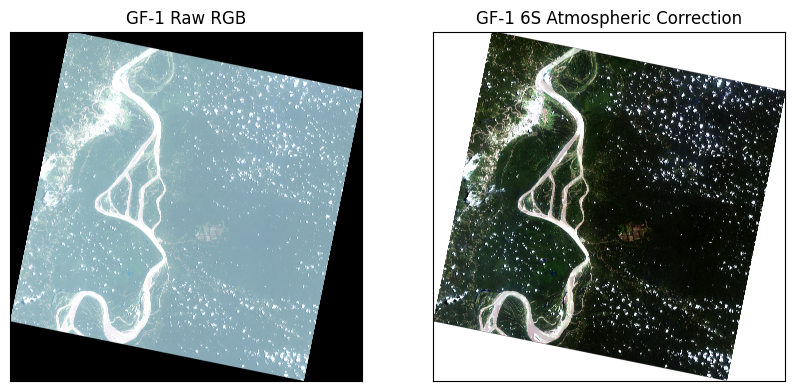

In [20]:
# View result in Raw RGB and surface refectance (6S Model) 
fig, axv = plt.subplots(1,2,figsize = (10,10))
ep.plot_rgb(ortho,rgb=(2,1,0),ax = axv[0],title="GF-1 Raw RGB",stretch=True,str_clip=4)
ep.plot_rgb(Reflectancia,rgb=(2,1,0),ax = axv[1],title="GF-1 6S Atmospheric Correction",stretch=True,str_clip=4)

(array([8.9575900e+05, 2.1736180e+06, 7.8311600e+05, 9.4708900e+05,
        1.0064080e+06, 2.2485750e+06, 1.4432884e+07, 2.7977829e+07,
        1.4364581e+07, 3.6579900e+06, 7.7127600e+05, 1.7789900e+05,
        6.2510000e+04, 2.6600000e+04, 1.0229000e+04, 4.0110000e+03,
        2.0660000e+03, 6.9900000e+02, 3.0000000e+01, 7.0000000e+00]),
 array([  8.99090263,  14.08534383,  19.17978504,  24.27422624,
         29.36866744,  34.46310864,  39.55754985,  44.65199105,
         49.74643225,  54.84087345,  59.93531465,  65.02975586,
         70.12419706,  75.21863826,  80.31307946,  85.40752066,
         90.50196187,  95.59640307, 100.69084427, 105.78528547,
        110.87972668]),
 <BarContainer object of 20 artists>)

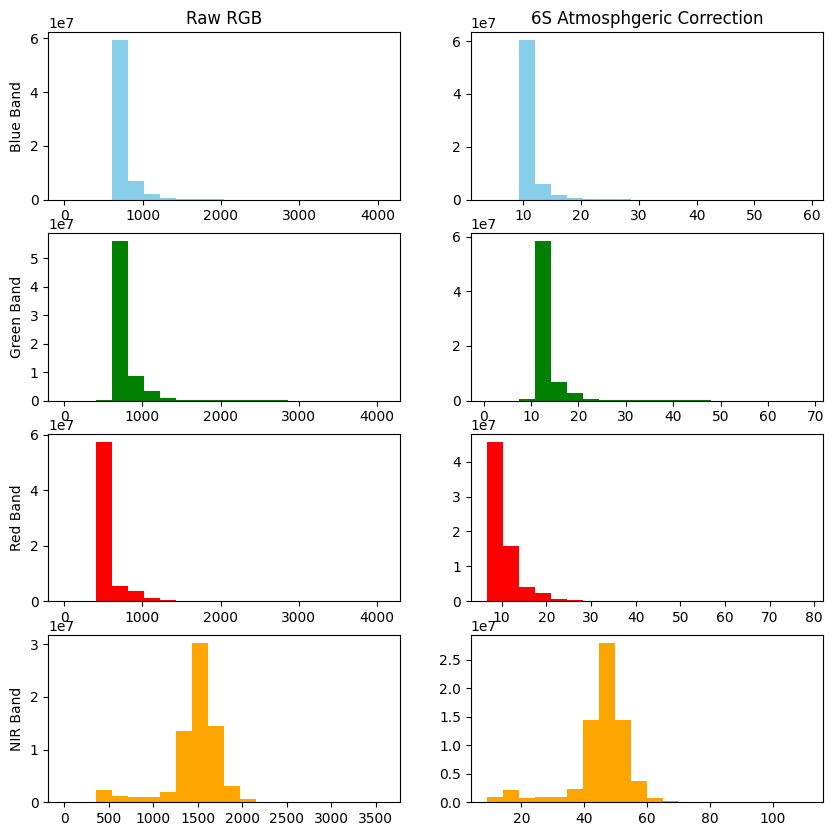

In [21]:
# Histogram Display
fig, axh = plt.subplots(4,2,figsize = (10,10))
axh[0,0].hist(BAND['B1'].flatten(),bins=20,range=(1, b1.max()),color='skyblue')
axh[0,0].set_title('Raw RGB')
axh[0,0].set_ylabel('Blue Band')
axh[0,1].hist(blue.flatten(),bins=20,color='skyblue')
axh[0,1].set_title('6S Atmosphgeric Correction')
axh[1,0].hist(BAND['B2'].flatten(),bins=20,range=(1, b2.max()),color='green')
axh[1,0].set_ylabel('Green Band')
axh[1,1].hist(green.flatten(),bins=20,color='green')
axh[2,0].hist(BAND['B3'].flatten(),bins=20,range=(1, b3.max()),color='red')
axh[2,0].set_ylabel('Red Band')
axh[2,1].hist(red.flatten(),bins=20,color='red')
axh[3,0].hist(BAND['B4'].flatten(),bins=20,range=(1, b4.max()),color='orange')
axh[3,0].set_ylabel('NIR Band')
axh[3,1].hist(nir.flatten(),bins=20,color='orange')

In [22]:
# Save atmospherically corrected image 
param = metada1
param['dtype'] = 'float32'
fileo6s=dir_atcor+_blash()+"R6S_"+lista[0] #"GF1B_PMS_W73.7_S3.9_20200826_L1A1227858642-MUX.TIF"
try:
    with rasterio.open(fileo6s,'w',**param) as  dst:
        dst.write(Reflectancia)
except NameError:
    print('variable no definido')
except ValueError:
    print('el valor no es valido')
else:
    print('se guardo satisfactoriamente')

se guardo satisfactoriamente


In [23]:
# Define vegetation inde - VIs
def computeNDVIband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_red = sat_data[2].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    ndvi = (band_nir - band_red) / (band_nir + band_red)
    return ndvi

def computeGNDVIband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_green = sat_data[1].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    gndvi = (band_nir - band_green) / (band_nir + band_green)
    return gndvi

def computeSRband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_red = sat_data[2].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    srvi = band_nir/band_red
    return srvi

def computeEVIband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_blue = sat_data[0].astype(float)  ## leer banda blue
    band_red = sat_data[2].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    evi = (2.5*(band_nir-band_red))/(band_nir+6.0*band_red-7.5*band_blue+1.0)
    return evi

def computeCIgband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_green = sat_data[1].astype(float)  ## leer banda green
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    cigreen = (band_nir/band_green)-1.0
    return cigreen

def computeCIrepband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_red = sat_data[2].astype(float)  ## leer banda red
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    cirep = (band_nir/band_red)-1.0
    return cirep

def computeMCARIband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_green = sat_data[1].astype(float)  ## leer banda green
    band_red = sat_data[2].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    mcari = 1.2*(2.5*(band_nir-band_red)-1.3*(band_nir-band_green))
    return mcari

def computeSAVIband(sat_data):
    ## indices de las bandas B,G,R,Nir -> 1,2,3,4
    band_red = sat_data[2].astype(float)  ## leer banda roja
    band_nir = sat_data[3].astype(float)  ## leer banda infraroja
    # Permitir la division por cero
    np.seterr(divide='ignore', invalid='ignore')
    savi = (1+0.5)*(band_nir-band_red)/(band_nir+band_red+0.5)
    return savi

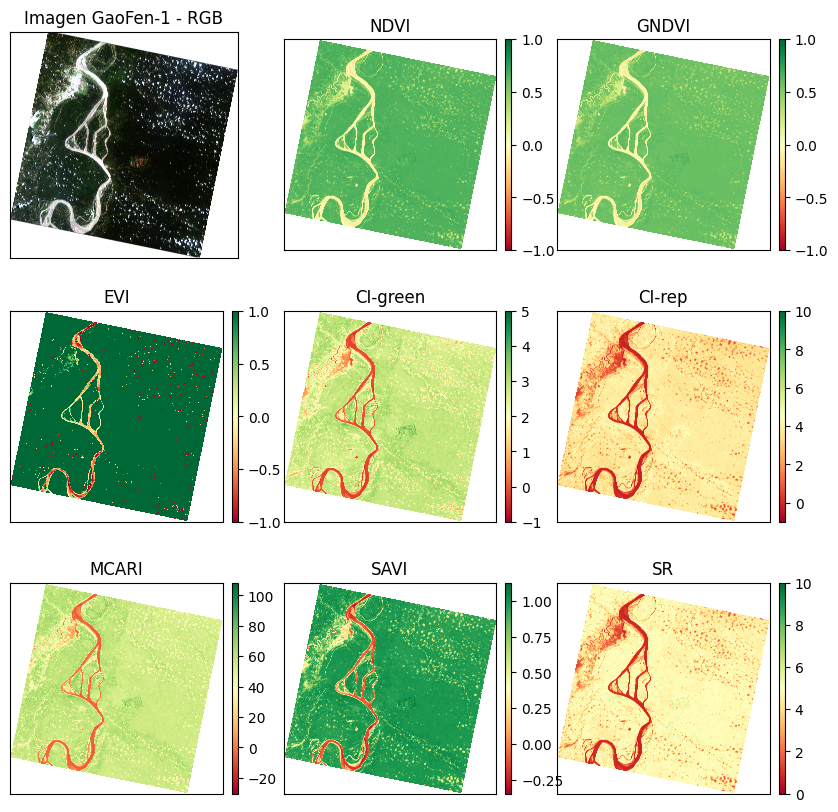

In [24]:
# Plot and tabulation the VIs
ndvi_band=computeNDVIband(Reflectancia)
gndvi_band=computeGNDVIband(Reflectancia)
srvi_band=computeSRband(Reflectancia)
evi_band=computeEVIband(Reflectancia)
cigreen_band=computeCIgband(Reflectancia)
cirep_band=computeCIrepband(Reflectancia)
mcari_band=computeMCARIband(Reflectancia)
savi_band=computeSAVIband(Reflectancia)
fig, ax = plt.subplots(3,3,figsize = (10,10))
ep.plot_rgb(Reflectancia,rgb=(2,1,0),ax = ax[0,0],title="Imagen GaoFen-1 - RGB",stretch=True,str_clip=4)
ep.plot_bands(ndvi_band, cmap="RdYlGn", ax = ax[0,1],title="NDVI",vmin=-1, vmax=1)
ep.plot_bands(gndvi_band, cmap="RdYlGn", ax = ax[0,2],title = "GNDVI",vmin=-1, vmax=1)
ep.plot_bands(evi_band, cmap="RdYlGn", ax = ax[1,0],title = "EVI",vmin=-1, vmax=1)
ep.plot_bands(cigreen_band, cmap="RdYlGn", ax = ax[1,1],title = "CI-green", vmin=-1, vmax=5)
ep.plot_bands(cirep_band, cmap="RdYlGn", ax = ax[1,2],title = "CI-rep", vmin=-1, vmax=10)
ep.plot_bands(mcari_band, cmap="RdYlGn", ax = ax[2,0],title = "MCARI")
ep.plot_bands(savi_band, cmap="RdYlGn", ax = ax[2,1],title = "SAVI")
ep.plot_bands(srvi_band, cmap="RdYlGn", ax = ax[2,2],title = "SR",vmin=0, vmax=10)
plt.savefig("F:/IVs-GF1-1200dpi.png")

5576 5539
2187 2115
3461 1901
   wavelengths  r_Cultivo    r_Suelo     r_Agua
0          450  10.760961  28.465110  11.094454
1          520  13.500992  42.072217  12.583108
2          620  11.292856  54.385931   8.956253
3          770  55.032069  72.178009  10.532804


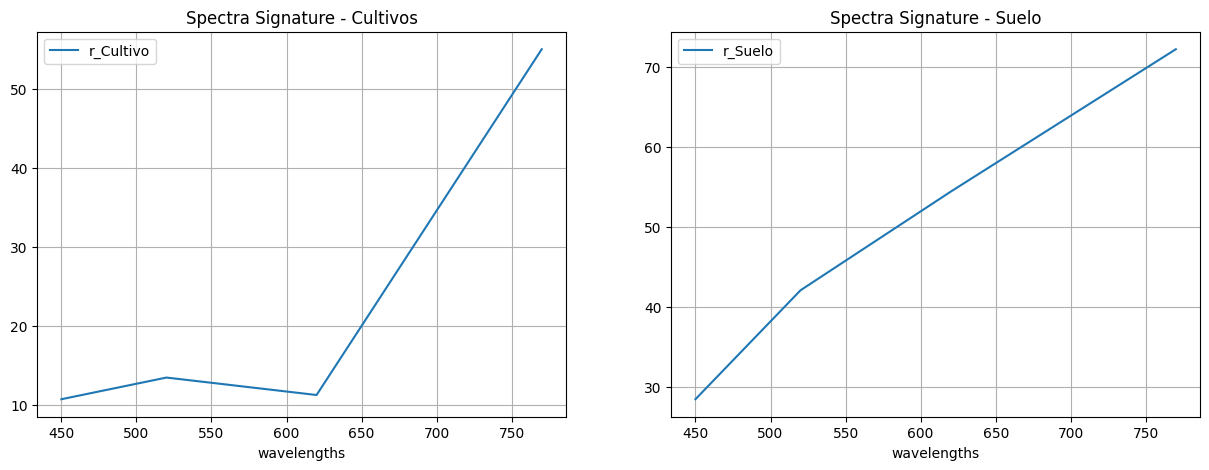

In [25]:
# Plot spectral signature of coverages 
import pandas as pd
import pyproj

proj = pyproj.Transformer.from_crs(4326,data1.crs,always_xy=True) #Transforma geograficas a UTM
pes_pixel = pd.DataFrame()
wavelengths=[450,520,620,770] #Longitd de onda central de las bandas GaoFen-1

##Coordenada de pixel - Cultivos
xlon1= -73.0596008  # E=610484.063
ylat1= -3.98170897 # N=9325505.625
xs1,ys1 = proj.transform(xlon1, ylat1)
row1, col1 = rasterio.transform.rowcol(data1.transform,xs1,ys1) #convierte UTM a (fil, columna)
print(row1, col1)
##Coordenada de pixel - Suelo (Playa)
xlon2= -73.3044981  # E=610484.063
ylat2= -3.73590708 # N=9325505.625
xs2,ys2 = proj.transform(xlon2, ylat2)
row2,col2 = rasterio.transform.rowcol(data1.transform,xs2,ys2) #convierte UTM a (fil, columna)
print(row2, col2)
##Coordenada de pixel - Agua (Laguna)
xlon3= -73.3202919  # E=610484.063
ylat3= -3.82773775 # N=9325505.625
xs3,ys3 = proj.transform(xlon3, ylat3)
row3,col3 = rasterio.transform.rowcol(data1.transform,xs3,ys3) #convierte UTM a (fil, columna)
print(row3, col3)
pes_pixel['wavelengths'] = wavelengths
pes_pixel['r_Cultivo'] = Reflectancia[:,row1,col1]
pes_pixel['r_Suelo'] = Reflectancia[:,row2,col2]
pes_pixel['r_Agua'] = Reflectancia[:,row3,col3]
print(pes_pixel)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
pes_pixel.plot(ax=ax1,x='wavelengths',y='r_Cultivo',kind='line');
ax1.set_title('Spectra Signature - Cultivos')
ax1.grid('on'); 

ax2 = fig.add_subplot(1,2,2)
pes_pixel.plot(ax=ax2,x='wavelengths',y='r_Suelo',kind='line');
ax2.set_title('Spectra Signature - Suelo')
ax2.grid('on'); 

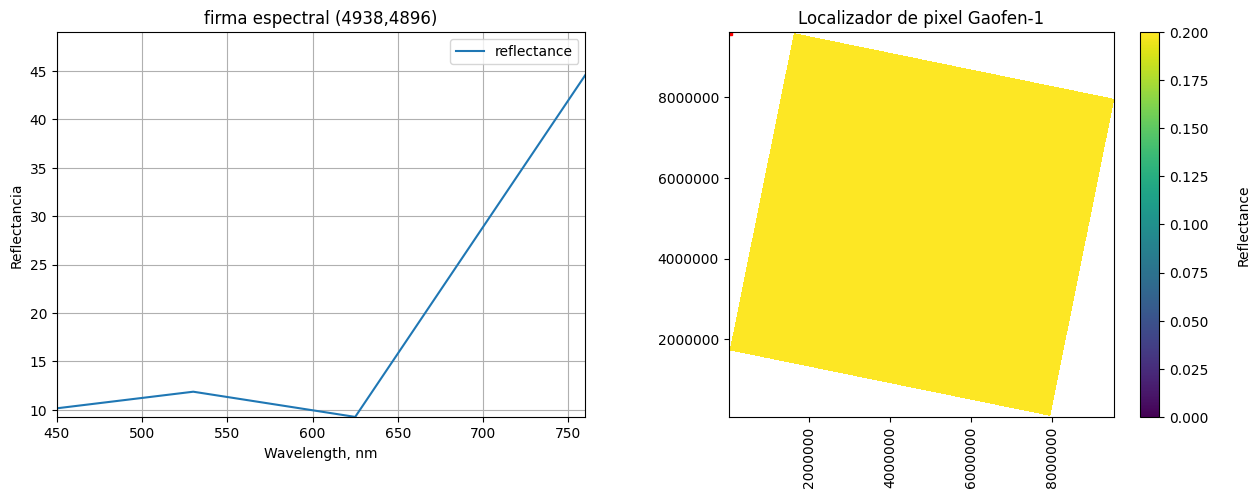

interactive(children=(IntSlider(value=4938, description='pixel_x', max=9876), IntSlider(value=4896, descriptio…

<function __main__.spectraPlot(pixel_x, pixel_y)>

In [28]:
#ALTERNATIVAMENTE PUEDE ISAR UN LOCALIZADOR DE PIXELES ITERATIVO
import ipywidgets as widgets
from ipywidgets import *
refl_band=Reflectancia[3,:,:]

def spectraPlot(pixel_x,pixel_y):
    reflectance = Reflectancia[:,pixel_y,pixel_x]
    #reflectance[nan_ind]=np.nan
    
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = [450,530,625,760]

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='line');
    ax1.set_title('firma espectral (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths'])]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectancia")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=data1.bounds ,clim=(0,0.2)); 
    plt.title('Localizador de pixel Gaofen-1'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('viridis'); #terrain, viridis,gist_earth
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #No uso de Notacion cientifica 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotar etiquetas-x 90 grados
    
    ax2.plot(data1.bounds[0]+pixel_x,data1.bounds[3]-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(data1.bounds[0],data1.bounds[1])
    ax2.set_ylim(data1.bounds[2],data1.bounds[3])
    
interact(spectraPlot, pixel_x = (0,Reflectancia.shape[2]-1,1),pixel_y=(0,Reflectancia.shape[1]-1,1))